# Lab/ Audio/ Multi-Pitches estimation

Author: Geoffroy Peeters

Last edit: 2024/12/09 (moved to colab)



In [1]:
import gdown
gdown.download('https://drive.google.com/uc?id=194qZ9AbvIxSp4vcYuORTkNtvyGZTI6rr', 'tpt_tools.py', quiet=True)
gdown.download('https://drive.google.com/uc?id=1AeVKgWvDwLmU4a1ky93p6vI3zLYOP8pc', '_audio.zip', quiet=True)
gdown.download('https://drive.google.com/uc?id=1bo7_VEjxeIGBMP-cf91HeUltNe0UpMGX', '_images.zip', quiet=True)
! unzip _audio.zip -r
! unzip _images.zip -r

import numpy as np
import scipy.io.wavfile
from scipy.signal import convolve2d, find_peaks
import matplotlib.pyplot as plt
import sys
import tpt_tools
from IPython.display import Image

do_student = True

Archive:  _audio.zip
caution: filename not matched:  -r
Archive:  _images.zip
caution: filename not matched:  -r


## Introduction

L’objectif de ce TP est de réaliser un module d’estimation de fréquences fondamentales multiples d’un signal de musique (i.e. de déterminer à partir du signal audio les notes de musique jouées).
Il existe de nombreuses approches pour résoudre ce problème.
Nous étudions ici une technique simple inspirée par les travaux de A. Klapuri [1, 2].

Cette approche consiste à
- dans un premier temps estimer la fréquence fondamentale dominante
- à en déduire la position et l’amplitude de ses harmoniques sur le spectre
- et à soustraire la contribution du son correspondant.

Ce principe est ensuite itéré à chaque fois sur le signal soustrait afin d’extraire progressivement l’ensemble des fréquences fondamentales.

Il est ensuite proposé de mettre en place le principe de la **continuité de l’enveloppe spectrale** (spectral smoothness) qui sera appliqué au préalable de la soustraction fréquentielle.

Les performances de ces approches seront testées et comparées sur différents accords composés de notes de piano, de flute et de hautbois.

La figure résume les différentes étapes de l’algorithme.

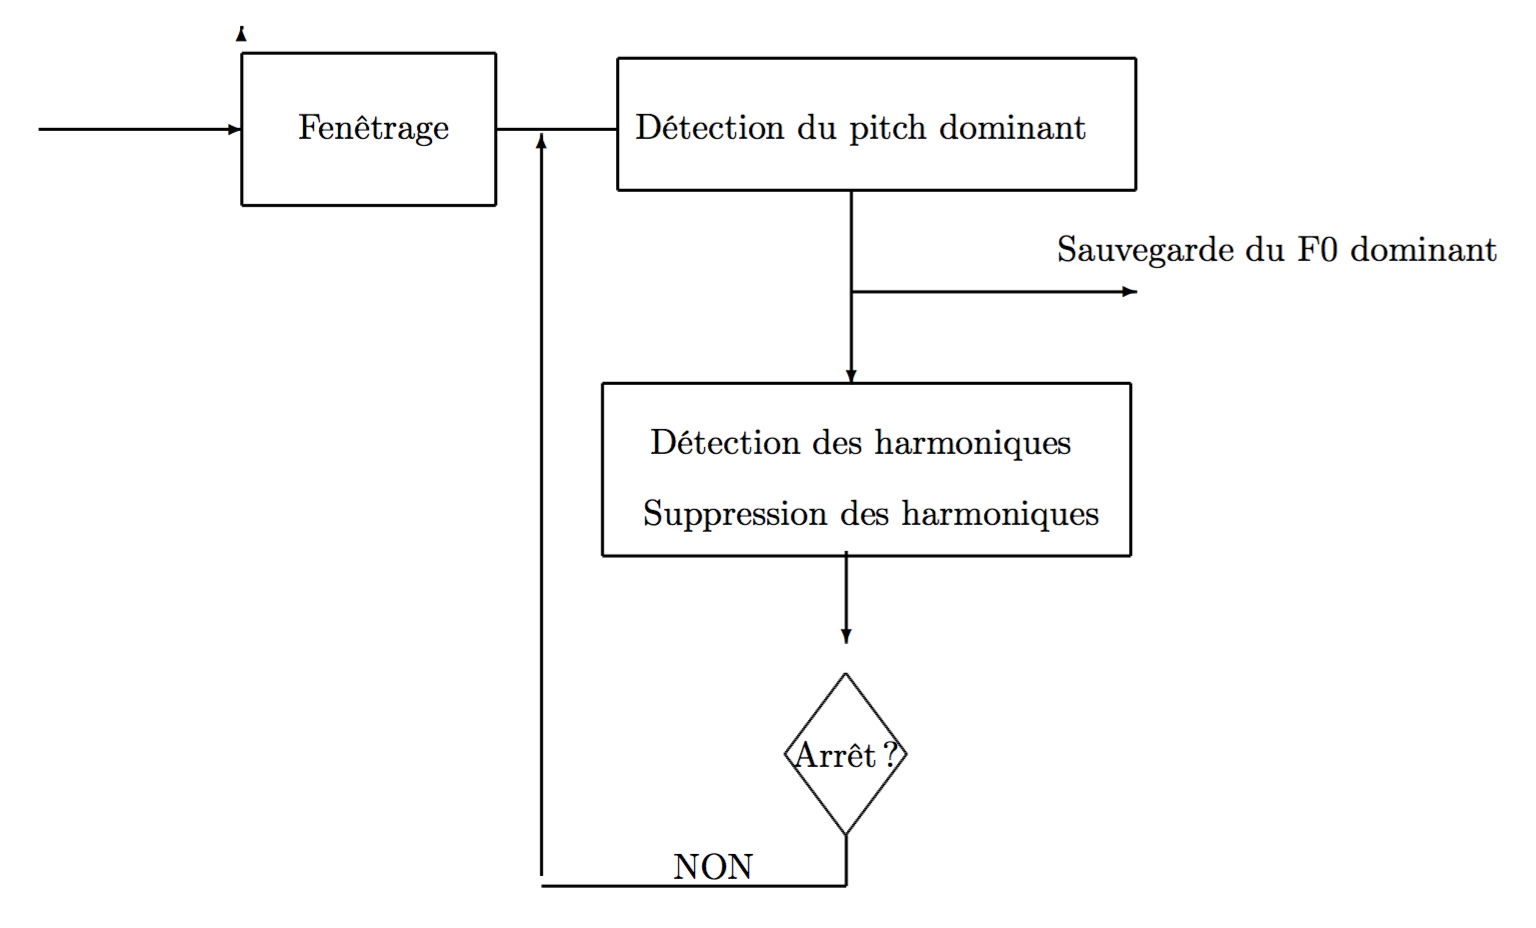

In [ ]:
Image('_images/TP_multiPitch_schema.png', width=600)

Nous sélectionner le fichier audio à étudier.

In [2]:
#audioFile = './_audio/A3_piano.wav'# 220 Hz
#audioFile = './_audio/A4_piano.wav' # 440 Hz
#audioFile = './_audio/E4_oboe.wav' # 329 Hz
#audioFile = './_audio/A5_flute.wav' # 880
#audioFile = './_audio/A3A4_piano.wav' # 220, 440
#audioFile = './_audio/A3A4A5_duo.wav' # 220, 440, 880
audioFile = './_audio/A3C4E4G4_piano.wav' # 220, 261, 329, 392 Hz

In [3]:
sr_hz, data_v = scipy.io.wavfile.read(audioFile)

fmin_hz = 50
fmax_hz = 900
H = 4
L_sec = 0.1

L_n = int(L_sec*sr_hz)
Nfft = 4*tpt_tools.nextpow2(L_n)

import IPython.display as ipd
ipd.Audio(audioFile)

# Estimation de la fréquence fondamentale par la méthode du produit spectral

Nous allons estimer ici la fréquence fondamentale $f_0$ d’un signal discret $x(n)$ échantillonné à la fréquence $sr_{hz}$.
La valeur $f_0$ sera recherchée dans un intervalle $[F_{min},F_{max}]$, avec une **précision** au moins égale à $dF$.
La valeur de $dF$ s'obtient à partir du nombre de points de la DFT et du taux d'échantillonnage $dF = \frac{sr_{hz}}{N_{fft}}$.
Par défaut, nous utiliserons $F_{min}$ = 50 Hz, $F_{max}$ = 900 Hz.

Nous allons utiliser la méthode du **produit spectral**.
Celui-ci est calculé en multipliant $H$ versions compressées du spectre.

Si nous notons $f_k = \frac{k}{N_{fft}}$ les fréquences discrètes de la DFT, le produit spectral est donné par:
\begin{equation}
    P(f_k) = \prod_{h=1}^{H} |X(h \cdot f_k)|
\end{equation}
Par défaut nous utiliserons $H$ = 4.

Les différentes étapes de ce calcul sont détaillées ci-dessous.

## Calcul du spectre (TFD) du signal

Dans un premier temps, nous calculons la transformée de Fourier discrète (TFD) du signal $x(n)$ sur $N_{fft}$ points.
Nous commençons par multiplier $x(n)$ par une fenêtre de hamming de taille $L_n$ (ceci afin de diminuer la hauteur des lobes secondaires).

La longueur $L_n$ ainsi que le type de cette fenêtre détermine la **résolution fréquentielle**, i.e. le pouvoir de séparer en fréquence deux sinusoides adjacentes.

Le nombre de points de la la DFT, $N_{fft}$, détermine lui la **précision fréquentielle**., i.e. la distance en Hz entre $f_k$ et $f_{k+1}$.
Il faut impérativement utiliser une valeur de $N_{fft}$ supérieure à $L_n$. En pratique $N_{fft}$ est choisi comme une puissance de 2 de manière à pouvoir utiliser l'algorithme de FFT (Fast Fourier Transform). Ceci peut se calculer à l'aide de la fonction ```nextpow2```.

Calculer ensuite la transformée de Fourier Discrète $X(k)$.

In [4]:
def F_getSpectreFromAudio(x, L_n, Nfft, sr_hz):
    """
    inputs:
        - x: signal
        - L_n: window duration in samples
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - fftFreq_hz_v (N/2+1,): vector containing the DFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the DFT amplitudes
    """

    if do_student:
        ### START CODE HERE ###
        win = np.hamming(L_n)
        win = np.concatenate((win, np.zeros(len(x)-L_n)))
        X = np.fft.fft(x * win, Nfft)
        fftAmpl_v = np.abs(X)
        fftAmpl_v = fftAmpl_v[:int(Nfft/2)]
        fftAmpl_v = fftAmpl_v / np.max(fftAmpl_v)
        freq = np.fft.fftfreq(Nfft, 1/sr_hz)
        fftFreq_hz_v = freq[:int(Nfft/2)]
        ### END CODE HERE ###

    # +++++++++++++++++++++++++++++++
    plt.figure(figsize=(10, 6))
    tpt_tools.F_plot1(fftFreq_hz_v, fftAmpl_v, 'Frequency [Hz]', 'Amplitude [lin]')
    plt.xlim((0,3000))
    # +++++++++++++++++++++++++++++++

    return fftFreq_hz_v, fftAmpl_v

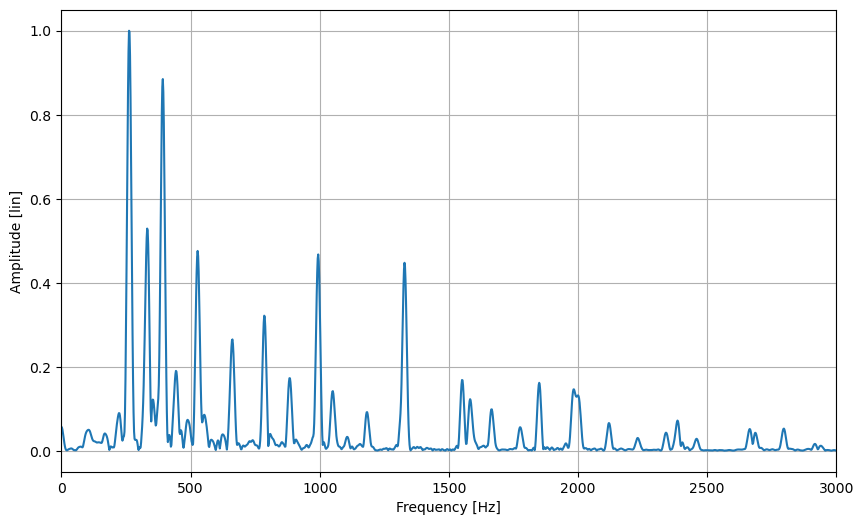

In [5]:
fftFreq_hz_v, fftAmpl_v = F_getSpectreFromAudio(data_v, L_n, Nfft, sr_hz)

### Test
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir


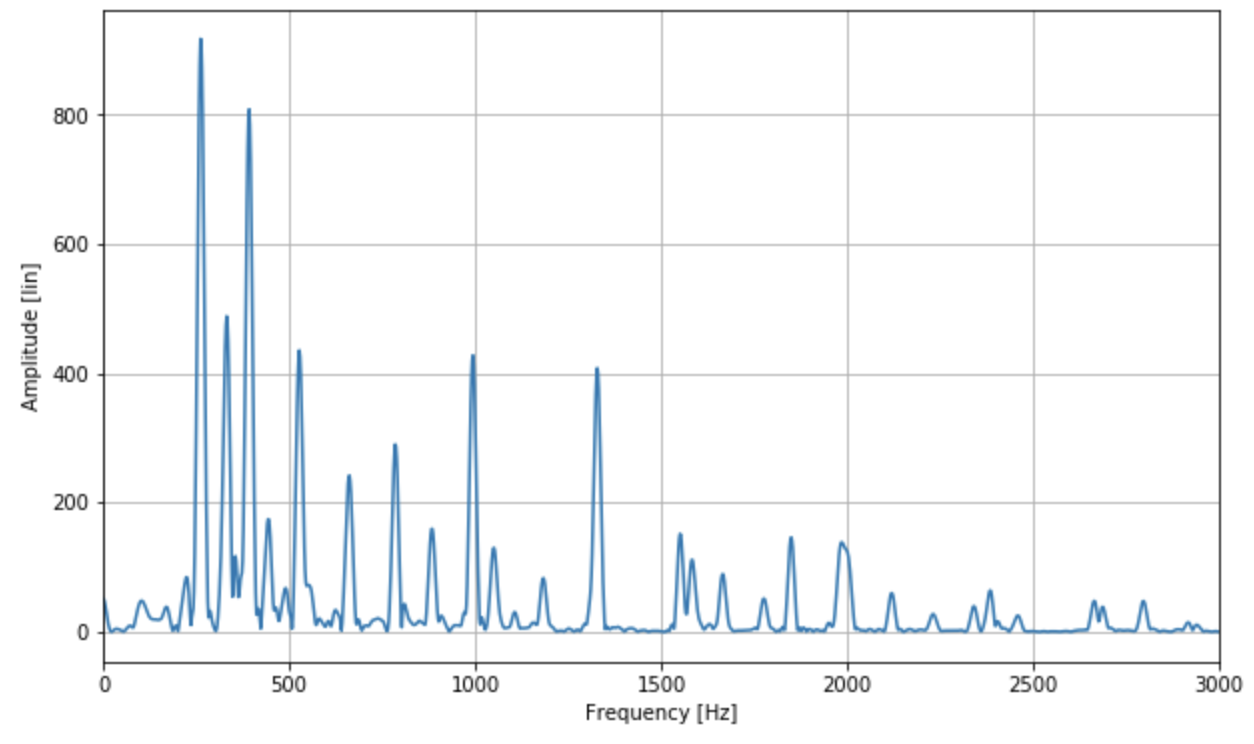

In [ ]:
Image('_images/TP_multiPitch_01.png', width=600)

## Calcul du produit spectral et recherche du maximum du produit spectral

Le produit spectral $P$ sera codé dans un vecteur de longueur $R$, couvrant l'intervalle $[0, R-1]$.
La fréquence maximale intervenant dans le calcul de $P$ sera donc $H \frac{R-1}{N_{fft}} sr_{hz}$.

En déduire (en fonction de $N_{fft}$ et de $H$) la valeur maximale de $R$ qui garantit de ne pas dépasser la fréquence de Nyquist ($\frac{sr_{hz}}{2}$).
Calculer ensuite $P$ en fonction de $|X|$.

Déterminer les valeurs entières $N_{min}$ et $N_{max}$ qui correspondent à l’intervalle $[F_{min},F_{max}]$ (on veillera à ce que $N_{max}$ reste inférieur à $R$).
Rechercher le maximum de $P$ sur l’intervalle $[N_{min},N_{max}]$, et en déduire la valeur de la fréquence fondamentale $f_0$.

On testera la fonction de détection de la fréquence fondamentale sur des signaux monophoniques (par exemple A4\_piano.wav ou E4\_oboe.wav).

In [6]:
def F_getF0FromSpectre(fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, sr_hz):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude
        - H: number of times the spectrum is decimated
        - fmin_hz: minimum frequency in Hz to look for F0
        - fmax_hz: maximum frequency in Hz to look for F0
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - spFreq_hz_v: vector containing the SpectralProduct frequencies in Hz
        - spAmpl_v: vector containing the SpectralProduct amplitudes
        - f0_hz: estimated F0 in Hz
    """

    if do_student:
        ### START CODE HERE ###
        Nmin = int(fmin_hz*Nfft/sr_hz)
        Nmax = int(fmax_hz*Nfft/sr_hz)
        P = np.zeros(fftAmpl_v.shape)
        for k in range(len(fftAmpl_v)):
            tmp = 1
            for h in range(1, H+1):
                if k*h < len(fftAmpl_v):
                    tmp = tmp * np.abs(fftAmpl_v[k*h])
            P[k] = tmp
        spAmpl_v = P
        spFreq_hz_v = fftFreq_hz_v
        f0_hz = spFreq_hz_v[np.argmax(spAmpl_v)]
        ### END CODE HERE ###

    # +++++++++++++++++++++++++++++++
    plt.figure(figsize=(10,6))
    tpt_tools.F_plot1(fftFreq_hz_v, fftAmpl_v/np.max(fftAmpl_v), 'Frequency [Hz]', 'Amplitude [lin]')
    plt.plot(spFreq_hz_v, spAmpl_v/np.max(spAmpl_v), 'r')
    plt.xlim((0,3000))
    plt.plot(f0_hz, 1, 'ro')
    # +++++++++++++++++++++++++++++++

    return spFreq_hz_v, spAmpl_v, f0_hz

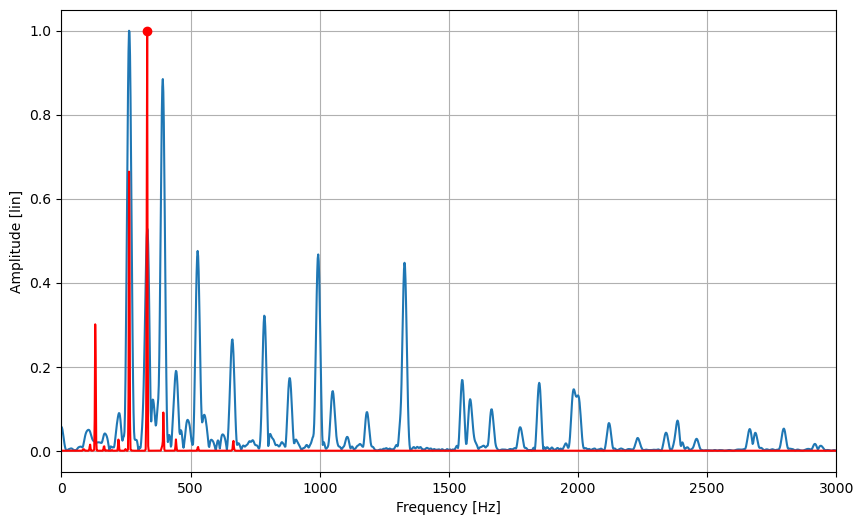

In [7]:
spFreq_hz_v, spAmpl_v, f0_hz = F_getF0FromSpectre(fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, sr_hz)

### Test
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir

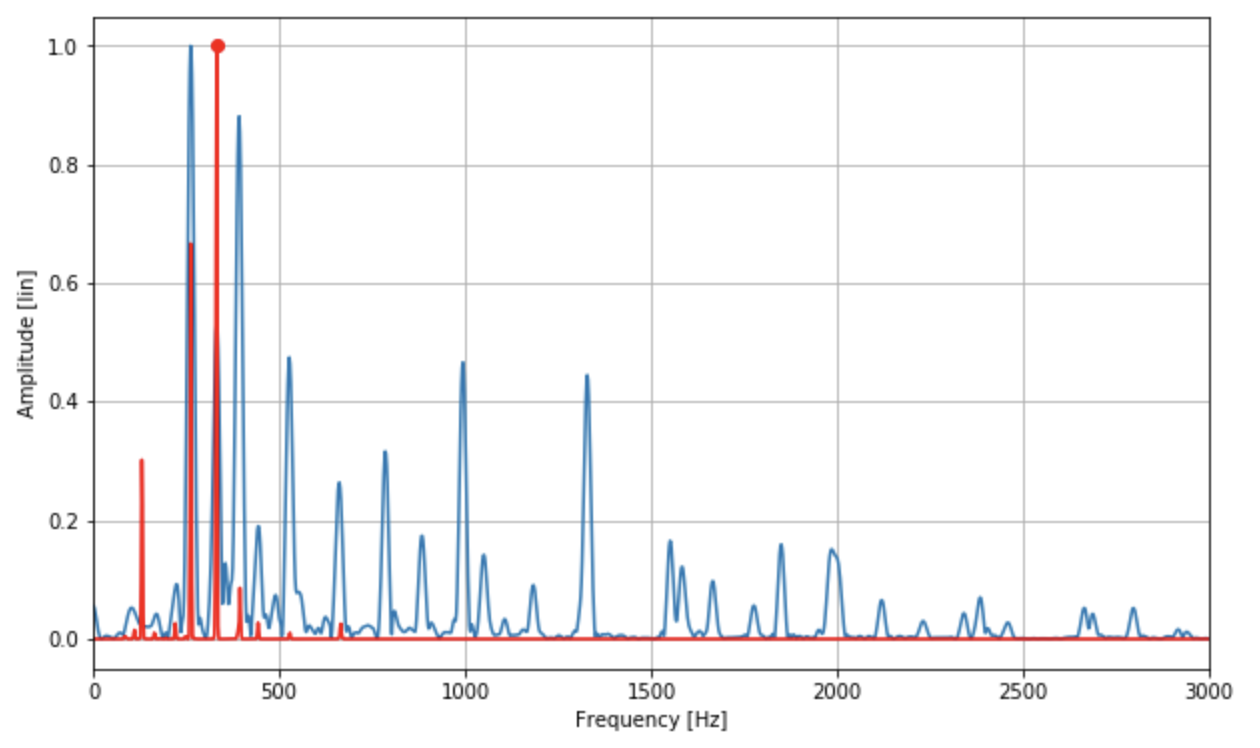

In [ ]:
Image('_images/TP_multiPitch_02.png', width=600)

# Soustraction du son correspondant à la fréquence fondamentale détectée

Dans les cas des signaux polyphoniques, plusieurs spectres harmoniques sont superposés.
Nous allons donc soustraire du spectre total, celui correspondant au spectre harmonique dont nous venons d'avoir estimer la $f_0$.

## Détection des harmoniques

Pour cela, nous devons d'abord connaitre la position des harmoniques du son de fréquence fondamentale $f_0$.
Une procédure simple consiste à rechercher le maximum du spectre autour de chaque **harmonique théorique** de fréquence $f_h = h \cdot f_0$.

L’intervalle de recherche autour de chaque harmonique $f_h$ est donné par $[f_{kmin}:f_{kmax}]$.
Afin de tenir compte de l'inharmonicité des sons, on pourra choisir $f_{kmin} = (1-\alpha) f_{inharmo}$ et $f_{kmax} = (1+\alpha) f_{inharmo}$ avec $f_{inharmo} = h f_0 \sqrt{1+(h^2-1) \beta}$ où $\beta$ est le coefficient d’inharmonicité (ce qui correspond à un bon modèle d’inharmonicité dans le cas du piano).

On pourra par ailleurs appliquer cette recherche également pour $h$ = 1 afin d’affiner l’estimation de $f_0$.

Quel choix de $\alpha$, $\beta$ vous parait judicieux pour le piano ? pour le hautbois ?
Ce modèle de recherche des harmoniques vous parait-il judicieux ? Justifier.

**Résponse:**

In [8]:
def F_getHarmonicsFromF0AndSpectre(fftFreq_hz_v, fftAmpl_v, f0_hz, Nfft, sr_hz):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude
        - f0_hz: estimated F0 in Hz
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - harmoFreq_k_v: vector containing the position/index of the Harmonics (position in fftFreq_hz_v or fftAmpl_v)
        - harmoAmpl_v:  vector containing the Harmonic amplitudes
    """

    if do_student:
        ### START CODE HERE ###
        h = 1
        alpha = 0.1
        beta = 0.01
        harmoFreq_k_v = []
        while h*f0_hz < sr_hz/2:
            # print(f"-------h={h}--------")
            f_inharmo = h * f0_hz * np.sqrt(1 + (h**2 - 1) * beta)
            fmin = (1 - alpha) * f_inharmo
            fmax = (1 + alpha) * f_inharmo
            Nmin = int(fmin*Nfft/sr_hz)
            Nmax = int(fmax*Nfft/sr_hz)
            # print(f"f_inharmo={f_inharmo}")
            if Nmax > len(fftAmpl_v):
                Nmax = len(fftAmpl_v)
            if Nmin >= Nmax:
                break;
            # print(f"Nmin={Nmin}, Nmax={Nmax}")

            idx = np.argmax(fftAmpl_v[Nmin:Nmax])
            # print(f"idx={idx}")
            harmoFreq_k_v.append(idx + Nmin)
            h += 1
        harmoAmpl_v = fftAmpl_v[harmoFreq_k_v]
        ### END CODE HERE ###

    # +++++++++++++++++++++++++++++++
    plt.figure(figsize=(10,6))
    tpt_tools.F_plot1(fftFreq_hz_v, fftAmpl_v, 'Frequency [Hz]', 'Amplitude [lin]')
    plt.plot(fftFreq_hz_v, fftAmpl_v, 'b.')
    plt.plot(fftFreq_hz_v[harmoFreq_k_v], harmoAmpl_v, 'ro')
    plt.xlim((0,3000))
    # +++++++++++++++++++++++++++++++

    return harmoFreq_k_v, harmoAmpl_v

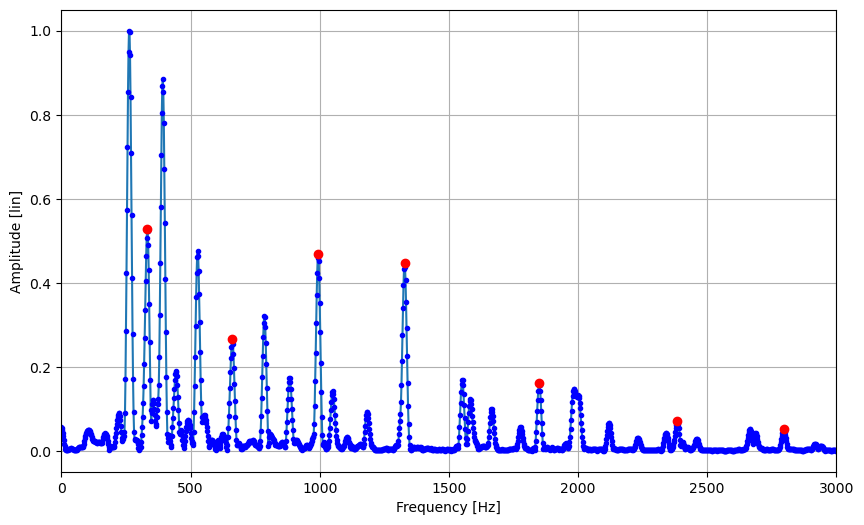

In [9]:
harmoFreq_k_v, harmoAmpl_v = F_getHarmonicsFromF0AndSpectre(fftFreq_hz_v, fftAmpl_v, f0_hz, Nfft, sr_hz)

### Test
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir


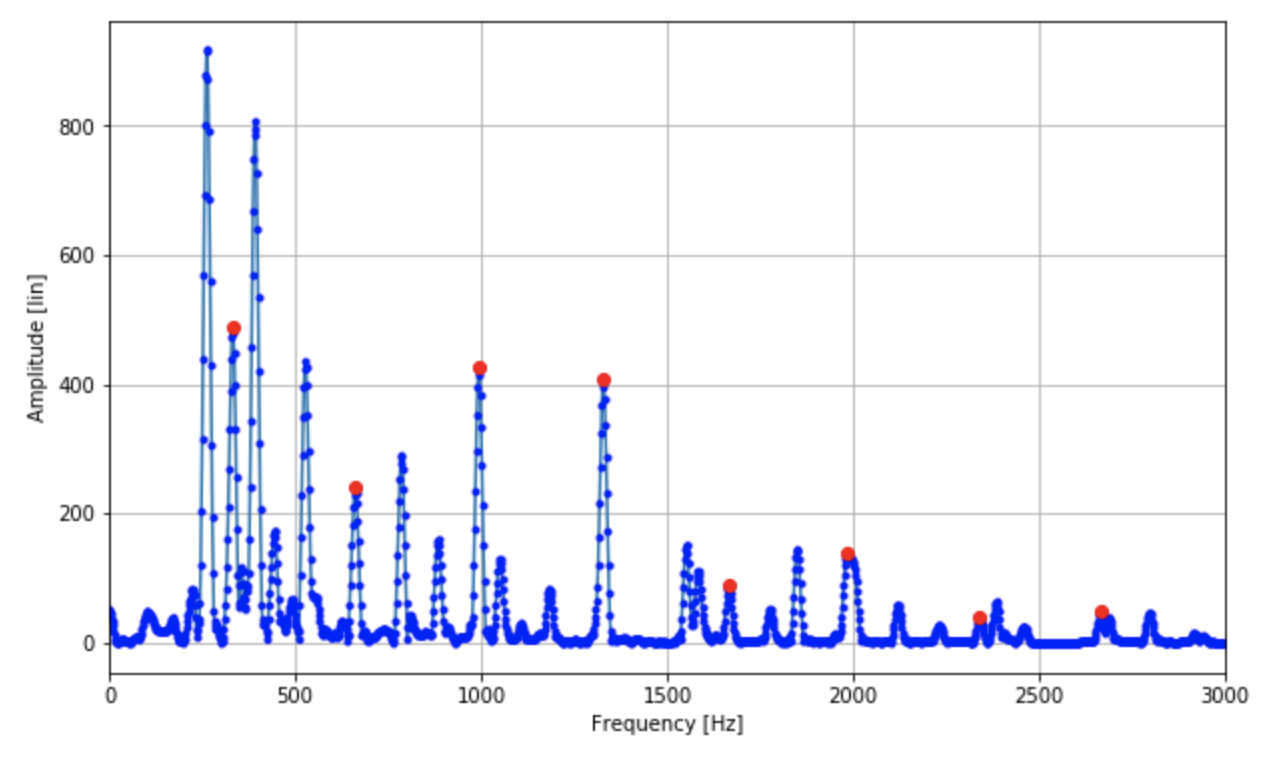

In [ ]:
Image('_images/TP_multiPitch_03.png', width=600)

## Suppression des harmoniques

Il s’agit ensuite de supprimer la totalité des harmoniques $f_h$ correspondant à un son donné.
- Pour cela, on calcul d'abord la largeur théorique d’un pic spectral (celui-ci dépend de la largeur $L_n$ de la fenêtre d’analyse utilisée).
- Ensuite, pour chaque harmonique $f_h$, on annule le spectre sur cette largeur théorique centrée sur $f_h$. Nous notons $a_h$ et $b_h$ les bornes de cet interval.

En raison de la technique d’estimation de la fréquence fondamentale utilisée, la mise à zéro des harmoniques perturbe les itérations ultérieures de l’algorithme.
Pour cette raison, on remplacera la mise à zéro par le forçage des valeurs du spectre autour de chaque harmonique $f_h$ au minimum du spectre sur cet intervalle ($|X(a_h : b_h)| = \min(|X(a_h : b_h))|$).

## Suppression des harmoniques avec application du principe du "spectral smoothness"

Afin de mieux discerner les sons qui sont en relation harmonique (et notamment les sons à l’octave) il est préférable de ne pas soustraire totalement un son de la mixture, mais d’essayer de ne soustraire que sa contribution au niveau de chaque harmonique.
Pour cela, on utilise le principe de la **continuité de l’enveloppe spectrale ("spectral smoothness")**.

Celui-ci consiste à calculer un spectre harmonique lissé où l’amplitude du spectre au niveau de chaque harmonique $f_h$ est remplacée par la moyenne des amplitudes des harmoniques $f_{h-1}$, $f_h$ et $f_{h+1}$. Cette nouvelle valeur, notée $|\hat{X}(f_h)|$ représente mieux la contribution du son harmonique de fréquence fondamentale $f_0$ que celle issue directement du spectre, notée $|X(f_h)|$. En effet ce dernier peut être le résultat d'une superposition d'harmoniques de différents sons.

Ensuite, la soustraction spectrale consiste à:

– Si $|X(f_h)|$ est inférieure à $|\hat{X}(f_h)|$ nous forçons les valeurs du spectre autour de chaque harmonique $f_h$ au minimum du spectre sur cet intervalle ($|X(a_h : b_h)| = \min(|X(a_h : b_h))|$)

– Si $|X(f_h)|$ est supérieure à $|\hat{X}(f_h)|$ nous forçons les valeurs du spectre autour de chaque harmonique $f_h$ à la différence entre le spectre et le spectre lissé sur cet intervalle $[a_h : b_h]$; pour éviter les valeurs négatives nous clipperons le résultat à un minimum de 0.

In [10]:
def F_cancelHarmonics(fftFreq_hz_v, fftAmpl_v, harmoFreq_k_v, harmoAmpl_v, L_sec, Nfft, sr_hz):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude
        - harmoFreq_k_v: vector containing the position/index of the Harmonics (position in fftFreq_hz_v or fftAmpl_v)
        - harmoAmpl_v:  vector containing the Harmonic amplitudes
        - L_sec: window duration in seconds
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - fftAmplSubtract_v (N/2+1,):  vector containing the FFT amplitude with amplitudes canceled at harmonic positions
    """


    Cw = 2.0 # === for a hanning window
    Bw_hz = Cw/(L_sec) # === this is the width at -3dB of the main lobe
    Bw_hz = 3*Bw_hz # === we extend it a bit since we want more than "at -3 dB"
    Bw_k = int(Bw_hz/sr_hz*Nfft)
    Bw_k = Bw_k +Bw_k % 2
    if do_student:
        ### START CODE HERE ###
        harmoAmplSmooth_v = []
        fftAmplSubtract_v = fftAmpl_v.copy()
        for k in range(len(harmoFreq_k_v)):
            amp_harmo_adj = []
            if k-1 >= 0:
                amp_harmo_adj.append(harmoAmpl_v[k-1])
            if k+1 < len(harmoFreq_k_v):
                amp_harmo_adj.append(harmoAmpl_v[k+1])
            amp_harmo_adj.append(harmoAmpl_v[k])
            X_hat = np.mean(amp_harmo_adj)
            harmoAmplSmooth_v.append(X_hat)

            f_k = harmoFreq_k_v[k]
            if fftAmpl_v[f_k] < X_hat:
                fftAmplSubtract_v[int(f_k-Bw_k/2) : int(f_k+Bw_k/2)] = np.min(fftAmpl_v[int(f_k-Bw_k/2) : int(f_k+Bw_k/2)])
            elif fftAmpl_v[f_k] > X_hat:
                fftAmplSubtract_v[int(f_k-Bw_k/2) : int(f_k+Bw_k/2)] = fftAmpl_v[int(f_k-Bw_k/2) : int(f_k+Bw_k/2)] - X_hat
                fftAmplSubtract_v[int(f_k-Bw_k/2) : int(f_k+Bw_k/2)] = np.maximum(fftAmplSubtract_v[int(f_k-Bw_k/2) : int(f_k+Bw_k/2)], 0)

        ### END CODE HERE ###

    # +++++++++++++++++++++++++++++++
    plt.figure(figsize=(10,6))
    plt.plot(fftFreq_hz_v, fftAmpl_v, 'b-')
    plt.plot(fftFreq_hz_v[harmoFreq_k_v], harmoAmpl_v, 'ro')
    plt.plot(fftFreq_hz_v[harmoFreq_k_v], harmoAmplSmooth_v, 'g+')
    plt.plot(fftFreq_hz_v, fftAmplSubtract_v, 'g-')
    plt.xlim((0,3000))
    # +++++++++++++++++++++++++++++++

    return fftAmplSubtract_v

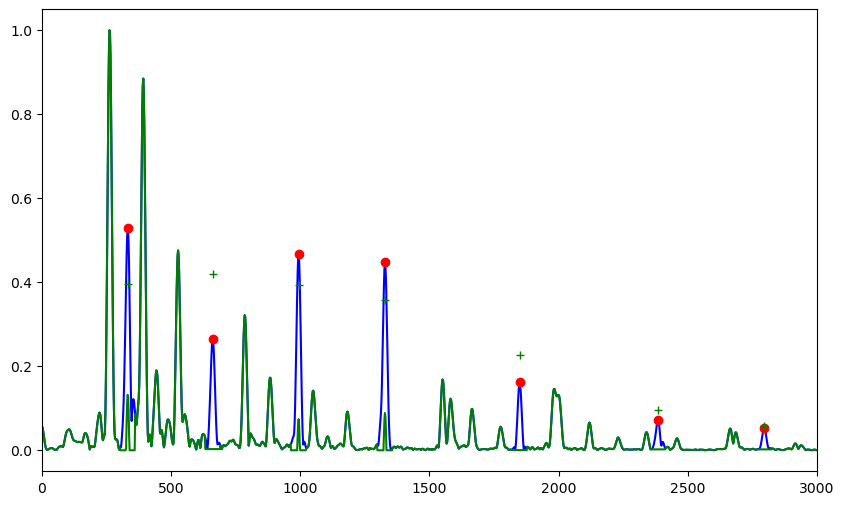

In [11]:
fftAmplSubtract_v = F_cancelHarmonics(fftFreq_hz_v, fftAmpl_v, harmoFreq_k_v, harmoAmpl_v, L_sec, Nfft, sr_hz)

### Test
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir



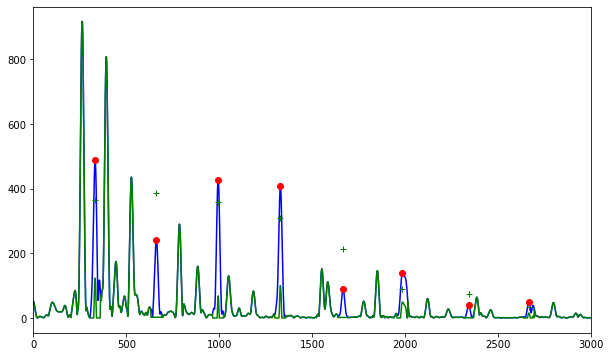

In [ ]:
Image('_images/TP_multiPitch_04.png', width=600)

## Critère d’arrêt

Les étapes précédentes (```F_getF0FromSpectre```,```F_getHarmonicsFromF0AndSpectre```,```F_cancelHarmonics```) sont ensuite itérées tant qu’un certain critère d’arrêt n’est pas vérifié.

Déterminer un critère d’arrêt qui vous permet d’arrêter l’itération lorsque le bon nombre de notes a été trouvé.

On testera l’algorithme sur les différents accords proposés.

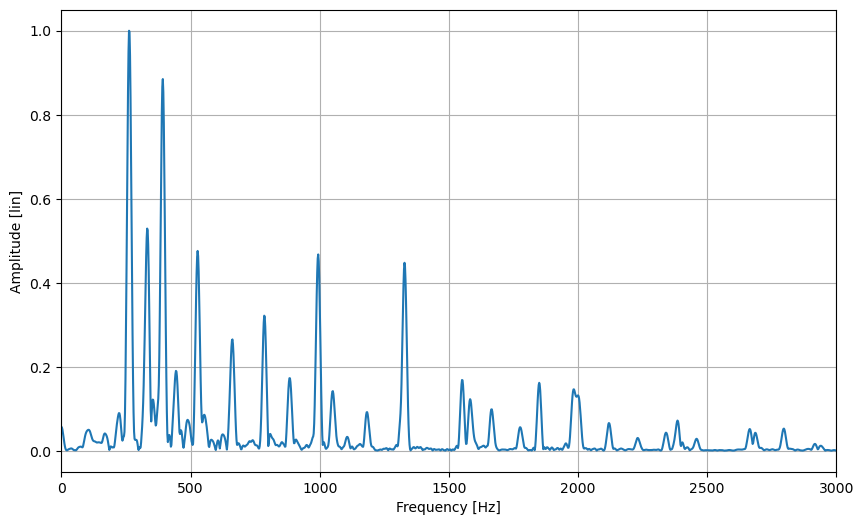

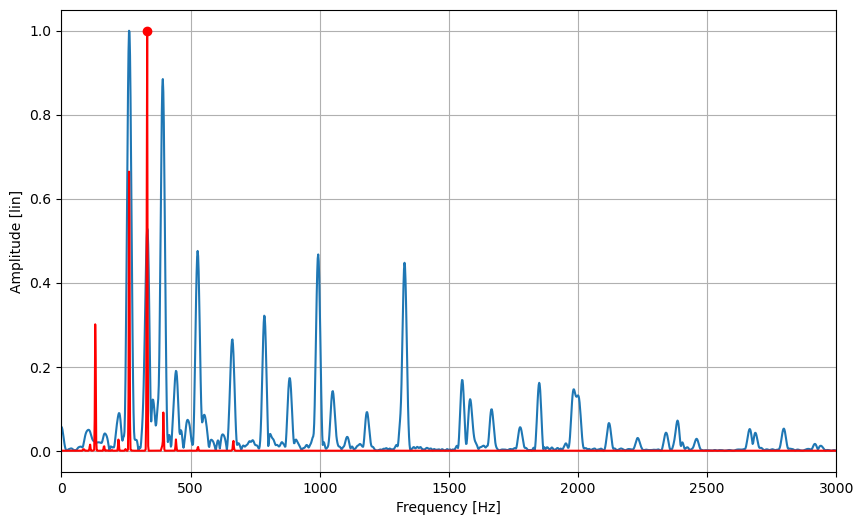

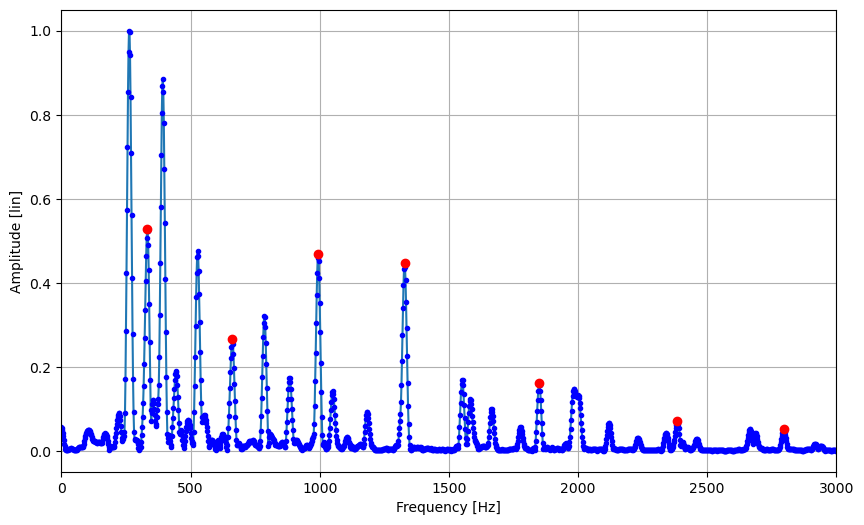

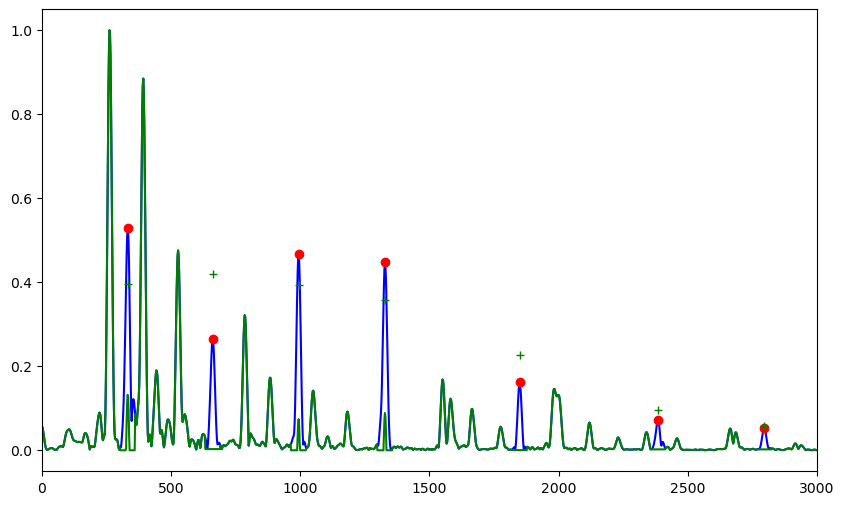

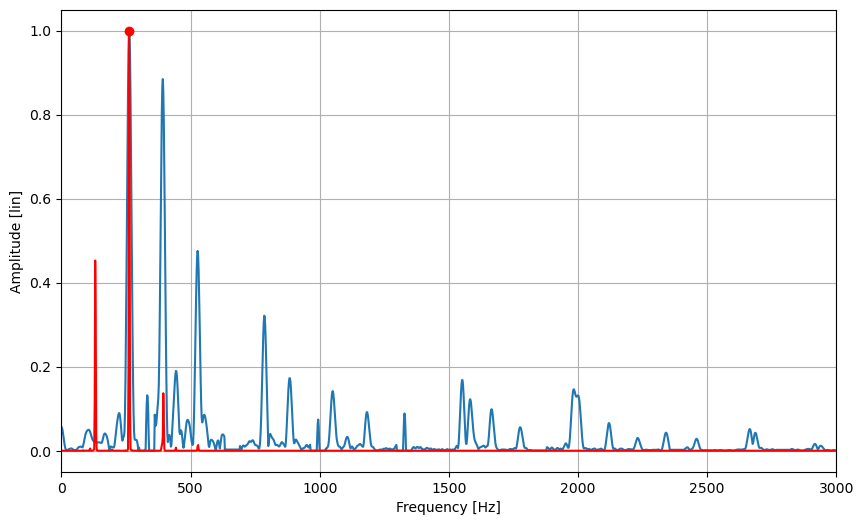

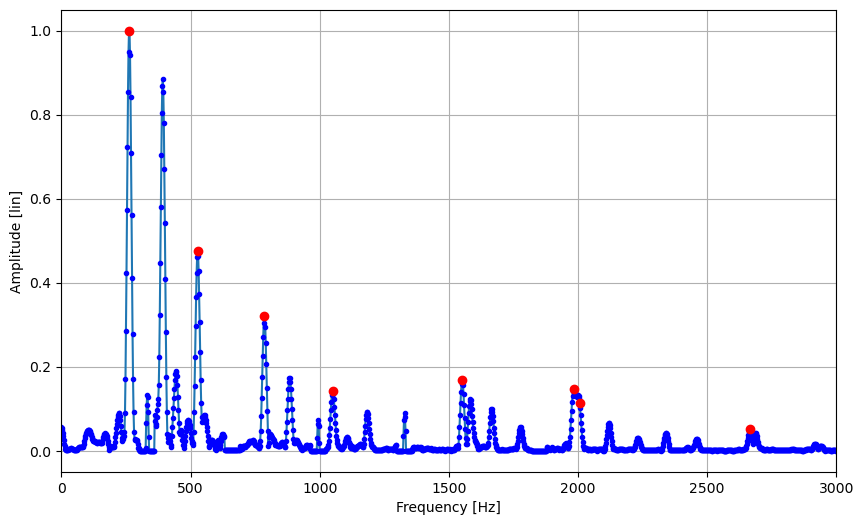

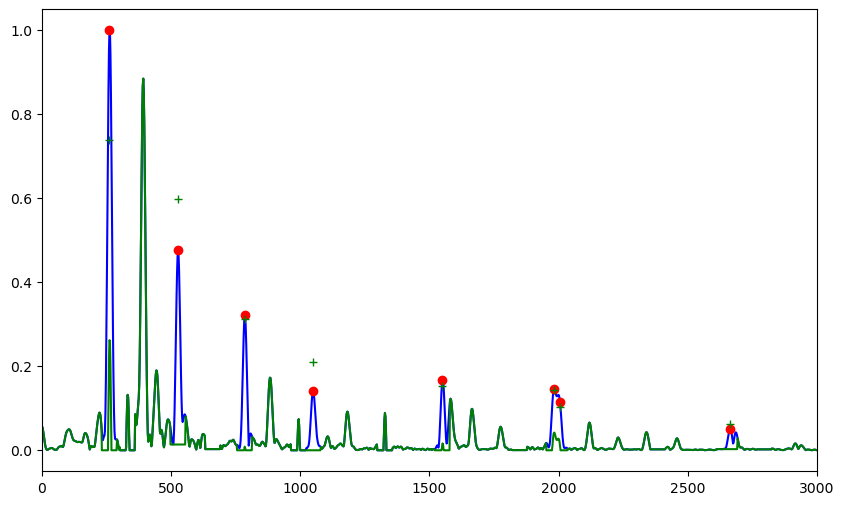

In [12]:
if do_student:
        ### START CODE HERE ###
        fftFreq_hz_v, fftAmpl_v = F_getSpectreFromAudio(data_v, L_n, Nfft, sr_hz)
        peaks = find_peaks(fftAmpl_v, height=0.4*np.max(fftAmpl_v))

        while(peaks[0].shape[0] >= 3):
                spFreq_hz_v, spAmpl_v, f0_hz = F_getF0FromSpectre(fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, sr_hz)
                if f0_hz < 50:  break
                harmoFreq_k_v, harmoAmpl_v = F_getHarmonicsFromF0AndSpectre(fftFreq_hz_v, fftAmpl_v, f0_hz, Nfft, sr_hz)
                fftAmplSubtract_v = F_cancelHarmonics(fftFreq_hz_v, fftAmpl_v, harmoFreq_k_v, harmoAmpl_v, L_sec, Nfft, sr_hz)
                fftAmpl_v = fftAmplSubtract_v
                peaks = find_peaks(fftAmpl_v, height=0.4*np.max(fftAmpl_v))

        ### END CODE HERE ###


# Bibliographie

- [1] A.P. Klapuri. Multipitch estimation and sound separation by the spectral smoothness principle. In Proceedings of IEEE International Conference on Acoustics, Speech and Signal Processing, ICASSP, May 2001. [Link](https://www.music.mcgill.ca/~ich/classes/mumt614/transcription/klapuriMultiplePitch.pdf)
- [2] A.P. Klapuri. Multiple fundamental frequency estimation by harmonicity and spectral smoothness. IEEE Trans. Speech and Audio Processing, 11(6) :804–816, 2003. [Link](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=e48c650c64c398a1674542bdbfbb42c773e7e2d2)